## AML Homework 4 Task 2
## UNI: hs3159 Name: Harguna Sood
## UNI: sv2609 Name: Siddhanth Vinay 

In [1]:
!pip install category_encoders
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 102kB 2.4MB/s 
     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=7af04540a03f32a388adf1b50c5258ff72f602c9193419f2eb76fc35bad2447e
  Stored in directory: /tmp/pip-ephem-wheel-cache-5qw8dpth/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.pipeline import  make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder 
from category_encoders.target_encoder import TargetEncoder
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer
import spacy
from sklearn.model_selection import GridSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data = pd.read_csv("/content/gdrive/My Drive/winemag-data-130k-v2.csv")

#### Using data for US

In [0]:
data = data.drop(["Unnamed: 0"], axis = 1)
data = data[data["country"] == "US"].reset_index(drop=True)
data = data.drop(["country"], axis = 1)

In [5]:
data.head()

,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
1,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
2,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
3,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
4,"Slightly reduced, this wine offers a chalky, t...",NaN,87,34.0,California,Alexander Valley,Sonoma,Virginie Boone,@vboone,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini


#### Extracting year from title

In [0]:
data["title"] = data["title"].str.extract(r'(\d{4})')

#### Using taster_name instead of taster_Twitter_handle as both will roughy give the same results, but taster_twitter_handle has more null values.

In [0]:
data = data.drop(["taster_twitter_handle"], axis = 1)

In [0]:
text_feat = ["description"] # can get year from title
low_card_cat_feat = ["region_2", "taster_name"]  # one hot encoding 
high_card_cat_feat = ["designation", "province", "region_1", "winery", "variety"] # target encoding
cont_feat = ["price", "title"]
target = ["points"]

## Removing outliers 

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


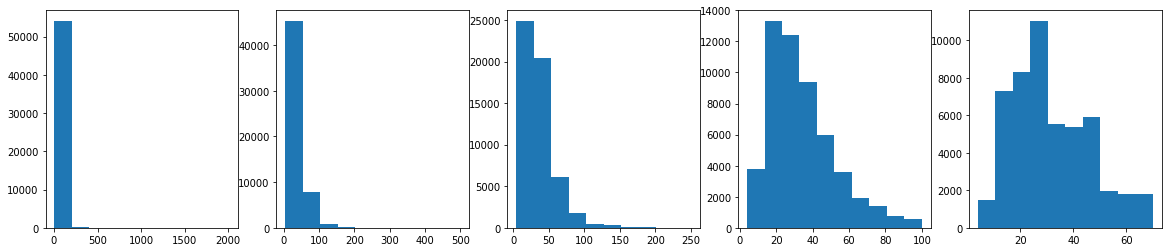

In [9]:
fig, ax = plt.subplots(1,5, figsize=(20, 4));
ax[0].hist(data["price"]);
ax[1].hist(data[data["price"]<=500]["price"]);
ax[2].hist(data[data["price"]<=250]["price"]);
ax[3].hist(data[data["price"]<=100]["price"]);
ax[4].hist(data[data["price"]<=70]["price"]);

In [10]:
data.shape

(54504, 11)

In [11]:
data = data[data["price"] <= 70]
data.shape

(50521, 11)

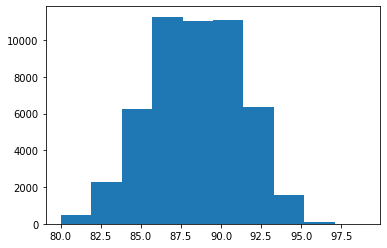

In [12]:
plt.hist(data["points"]);

## Null value treatment

In [13]:
data.isna().sum()

description        0
designation    16936
points             0
price              0
province           0
region_1         274
region_2        3885
taster_name    15416
title            904
variety            0
winery             0
dtype: int64

In [14]:
round((data.isna().sum()/data.shape[0])*100, 0)

description     0.0
designation    34.0
points          0.0
price           0.0
province        0.0
region_1        1.0
region_2        8.0
taster_name    31.0
title           2.0
variety         0.0
winery          0.0
dtype: float64

In [0]:
# by looking at percent of data missing in each column, dropping rows with null region_1 and  values
data = data[data["region_1"].notna() & data["title"].notna()]

# treating rest of missing values as a new "unknown" category
data = data.fillna("new_cat")

## Sampling and shuffling data

In [16]:
sample_data, a = tts(data, test_size=0.5, shuffle=False)
sample_data.shape

(24692, 11)

In [17]:
data_shuff = sample_data.sample(frac=1, random_state=5).reset_index(drop=True)
X = data_shuff.drop(target, axis = 1)
y = data_shuff[target]

xtrain, xtest, ytrain, ytest = tts(X, y, shuffle = False, test_size = 0.2)

xtrain_non_text = xtrain.drop(text_feat, axis = 1)

xtrain.shape

(19753, 10)

In [18]:
xtrain.head()

,description,designation,price,province,region_1,region_2,taster_name,title,variety,winery
0,Tempting aromas like fresh-baked bread and rip...,new_cat,22.0,California,North Coast,North Coast,Jim Gordon,2014,Chardonnay,La Follette
1,"Thick, rich and ripe in vanilla, the American ...",Barrel Select American Oak Reserve,34.0,California,Carneros,Napa-Sonoma,Virginie Boone,2013,Chardonnay,Roche
2,This barrel selection has long been Signorello...,Hope's Cuvee,65.0,California,Napa Valley,Napa,new_cat,2009,Chardonnay,Signorello
3,The alcohol is overwhelming here in an otherwi...,new_cat,32.0,California,Livermore Valley,Central Coast,Virginie Boone,2009,Petit Verdot,Cuda Ridge Wines
4,"Blended with 5% Sémillon, this crisp, tropical...",new_cat,28.0,California,Napa Valley,Napa,Virginie Boone,2015,Sauvignon Blanc,Merryvale


## 2.1

In [19]:
nlp = spacy.load("en_core_web_lg", disable=["tagger", "parser", "ner"])
docs_train = [nlp(d).vector for d in xtrain['description']]
X_train = np.vstack(docs_train)
X_train.shape

(19753, 300)

In [20]:
docs_test = [nlp(d).vector for d in xtest['description']]
X_test = np.vstack(docs_test)
X_test.shape

(4939, 300)

In [0]:
ridge_w2v = Ridge()
np.mean(cross_val_score(ridge_w2v,X_train,ytrain))

0.5291999978322376

In [0]:
ridge_w2v_grid  = GridSearchCV(ridge_w2v,
             param_grid={'alpha': [0.01,0.1,1, 10]})

In [0]:
ridge_w2v_grid.fit(X_train,ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.01, 0.1, 1, 10]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [0]:
ridge_w2v_grid.best_params_

{'alpha': 0.1}

In [0]:
ridge_w2v_grid.score(X_train,ytrain)

0.5452652068868125

In [0]:
ridge_w2v_grid.score(X_test,ytest)

0.5249636795401783

### We see that using word2vec alone gives a score of 0.525 on the test data.

## 2.2

In [0]:
X_train_combined =pd.concat([xtrain['description'],pd.DataFrame(X_train)],axis=1).reset_index(drop = True)
X_test_combined =pd.concat([xtest['description'],pd.DataFrame(X_test)],axis=1).reset_index(drop = True)

In [0]:
X_test_combined = pd.DataFrame(xtest['description'])
X_test_t = X_test.transpose()
for i in range(len(X_test_t)):
  X_test_combined[i] = X_test_t[i]

In [23]:
X_test_combined.head()

,description,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
19753,"Coming from a cool vintage, this shows notes o...",-0.087835,0.220784,-0.195399,-0.018553,0.036995,0.109718,-0.077490,-0.080908,-0.075364,1.584478,-0.070445,0.029889,-0.085423,-0.098759,-0.084579,-0.092608,-0.009120,1.202391,-0.152793,-0.182662,-0.024331,0.006978,0.058895,-0.051208,-0.105861,-0.059650,0.015340,0.089776,0.090473,-0.254913,0.013785,0.124241,0.002330,-0.050477,0.075674,-0.023101,-0.071932,0.035845,-0.110256,...,0.022104,0.068893,0.003842,0.286220,0.064811,-0.021111,-0.100642,-0.019035,0.115954,0.057437,-0.033098,-0.015028,-0.010925,-0.299525,-0.199766,-0.051648,0.043055,0.130235,-0.049844,0.288195,0.141770,0.068662,-0.016663,-0.161337,-0.084370,-0.014130,0.245583,-0.043417,0.191929,-0.120245,-0.123593,0.054399,-0.019500,-0.141139,-0.189016,0.051076,0.067945,-0.147543,-0.044744,0.081354
19754,Big flavors meet big tannins and full body in ...,-0.133318,0.143544,-0.140851,-0.084155,0.145936,0.051313,-0.036165,0.099609,-0.028091,1.708555,-0.046779,0.104762,-0.056887,-0.154735,-0.101902,-0.106058,-0.016416,1.145432,-0.090619,-0.124641,-0.041439,-0.042964,0.069170,0.026859,-0.052687,-0.082094,0.038501,0.060320,-0.014974,-0.203380,-0.004243,0.135374,-0.034866,-0.069223,0.060696,0.073601,-0.034447,-0.006272,-0.008878,...,0.093118,0.022473,0.028705,0.101095,0.088995,0.028703,-0.136974,0.021318,0.040921,0.040754,0.067333,-0.016927,-0.018995,-0.271766,-0.169293,0.000834,0.028692,0.171621,-0.003887,0.263722,0.116097,0.112751,-0.009279,-0.200285,-0.036034,-0.024643,0.242598,0.001248,0.175299,-0.065868,-0.136006,0.058661,-0.036030,-0.159138,-0.245696,0.012276,0.011853,-0.168598,-0.015460,0.071470
19755,A dark color and lots of fresh-fruit aromas le...,-0.097213,0.220340,-0.119215,-0.084741,0.116802,0.087163,-0.004766,0.053009,-0.049256,1.713745,-0.080521,0.109475,-0.142141,-0.119166,-0.115734,-0.145416,-0.034968,1.247268,-0.126107,-0.158354,-0.064113,-0.025110,0.023828,-0.045359,-0.008374,-0.092764,0.123313,0.078380,0.096104,-0.214418,-0.030899,0.115669,-0.050874,-0.090225,0.131647,-0.030816,-0.004971,-0.034411,-0.060521,...,0.052219,0.048216,0.045410,0.194110,0.093619,-0.067175,-0.166274,0.009510,0.118061,0.014385,-0.012348,0.032905,-0.023453,-0.275722,-0.210281,0.039333,0.062398,0.143928,-0.012783,0.369179,0.225779,0.078080,0.065537,-0.166659,-0.088129,0.000602,0.228459,0.058266,0.220634,-0.079443,-0.216000,0.069691,-0.094203,-0.159827,-0.187282,0.054797,0.062078,-0.254630,-0.015252,0.109346
19756,A roughly equal blend of Tempranillo and Grena...,-0.107777,0.163723,-0.057129,-0.113060,0.120171,0.035636,-0.072921,0.024556,0.047854,1.557607,-0.137306,0.066518,-0.163336,-0.077045,-0.008675,-0.120870,-0.081200,0.956406,-0.059023,-0.228800,-0.013903,-0.038537,0.027218,0.030198,0.005492,-0.106118,0.058155,0.017285,0.032006,-0.213616,0.022120,0.127560,-0.012610,0.023898,0.110933,-0.019412,0.018432,-0.045611,-0.070998,...,0.105321,0.032000,0.035421,0.069311,0.137816,-0.062882,-0.110404,-0.020011,0.061422,-0.048816,-0.005368,-0.041452,-0.053133,-0.245345,-0.177292,-0.053427,-0.078440,0.060500,0.001349,0.295367,0.169679,0.172181,0.048092,-0.196423,-0.062314,0.039577,0.188408,0.000164,0.140885,-0.064045,-0.125809,0.116862,-0.059992,-0.087129,-0.244728,0.006858,0.037542,-0.234999,0.018908,0.108007
19757,"A smoky, slightly rubbery aroma is off-putting...",-0.017378,0.178470,-0.100427,-0.010108,0.058156,0.045844,-0.026004,-0.001077,-0.022595,1.612384,-0.042105,0.087551,-0.101467,-0.118082,-0.085777,-0.166338,0.022786,1.164500,-0.053519,-0.187002,-0.053007,-0.010666,0.107780,0.029752,-0.037953,-0.078279,0.041216,0.053524,0.064117,-0.291399,-0.056044,0.066218,-0.040390,-0.115503,0.093891,-0.019307,0.042980,0.059341,-0.027995,...,0.050424,-0.023538,0.06619

In [0]:
text_pipe = make_pipeline(
    CountVectorizer(token_pattern=r'\b\w+\b', stop_words="english", #min_df=10, max_df = 20000,
                    ngram_range=(1,3), analyzer="char"),
    TfidfTransformer()
)

preprocess = make_column_transformer(
    (text_pipe, "description"),
    remainder = 'passthrough'
)

#pipeline
pipe = make_pipeline(preprocess, Ridge())

In [0]:
ridge_combined_grid  = GridSearchCV(pipe,
             param_grid={'ridge__alpha': [0.01,0.1,1, 10]})

In [35]:
ridge_combined_grid.fit(X_train_combined,ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('countvectorizer',
                                                                                          CountVectorizer(analyzer='char',
                                                                                                          binary=False,
     

In [36]:
ridge_combined_grid.best_params_

{'ridge__alpha': 1}

In [37]:
ridge_combined_grid.score(X_train_combined,ytrain)

0.7384022965534176

In [38]:
ridge_combined_grid.score(X_test_combined,ytest)

0.6754073764152402

## We see that the model using word2vec embeddings along with our best BOW model gives a score of 0.675 on the test data.

## R2 on test data using the 3 models:
### Baseline: 0.415
### (1,3) grams: 0.657
### Text + Non text: 0.727
### Word2Vec : 0.525
### Word2Vec + ngram : 0.675

### Thus, the model that performs best overall on the test data amongst these models is the model combining BOW ngram features and non-text features from task 1.4